In [2]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

<h1> Model </h1>

Jaynes-Cumming Hamiltonian with the rotation wave approximation (RWA) in units $\hbar = 1$:

$$H = \omega_c a^{\dagger} a + \omega_a \frac{\sigma_z}{2} + g (a^{\dagger}\sigma_{-} + a \sigma_{+}) $$

The RWA is valid when the detunning $\delta = |\omega_c - \omega_a|$ is low compared to the frequencies


<h3> Parameters </h3>

In [71]:
#frequencies and coupling

wc = 1.0  * 2 * pi  # cavity frequency
wa = 1.0  * 2 * pi  # atom frequency
g  = 0.05 * 2 * pi  # coupling strength


#environment

kappa = 0.005       # cavity dissipation rate
gamma = 0.05        # atom dissipation rate

#kappa = 0
#gamma = 0
n_th_a = 0.0        # avg number of thermal bath excitation


#number of states and RWA

N = 15              # number of cavity fock states
use_rwa = False

tlist = np.linspace(0,25,101)

<h3> Hamiltonian and initial state </h3>

One initializes the operators as:

$$ a = a^{(N)} \otimes I_2 $$
$$ \sigma_{-} = I_N \otimes \sigma_{-}^{(2)} $$

In [75]:
# intial state
psi0 = qt.tensor(qt.basis(N,3), qt.basis(2,1))    # start with an excited atom

# operators
a  = qt.tensor(qt.destroy(N), qt.qeye(2))
sm = qt.tensor(qt.qeye(N), qt.destroy(2))

# Hamiltonian
if use_rwa:
    H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())
else:
    H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() + a) * (sm + sm.dag())

<h3> Collpase operators for dissipation </h3>

Two operators model the dissipation in the cavity $V_d = V_d^{(atom)} + V_d^{(c)}$ with : 

$$V_d^{(atom)} = \sqrt{\kappa(1+n_b)} a $$
$$ V_d^{(c)} = \sqrt{\gamma} a $$

In [76]:
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

# cavity excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

# qubit relaxation
rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm)

<h3> Evolve the system </h3>

We evolve the system with the Lindblad master equation:

$$\dot{\rho}(t) = -\frac{i}{\hbar} [H(t), \rho(t)] + \frac{1}{2} \sum_n \left(2 C_n \rho(t) C_n^{\dagger} - \rho(t) C_n^{\dagger} C_n - C_n^{\dagger}C_n \rho(t) \right)$$

where $C_n = \sqrt{\gamma_n} A_n$ are the collapse operators. We request the expectation values of $a^{\dagger}a$ and $\sigma_{+} \sigma_{-}$.

In [77]:
output = qt.mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm])

<h3> Results </h3>

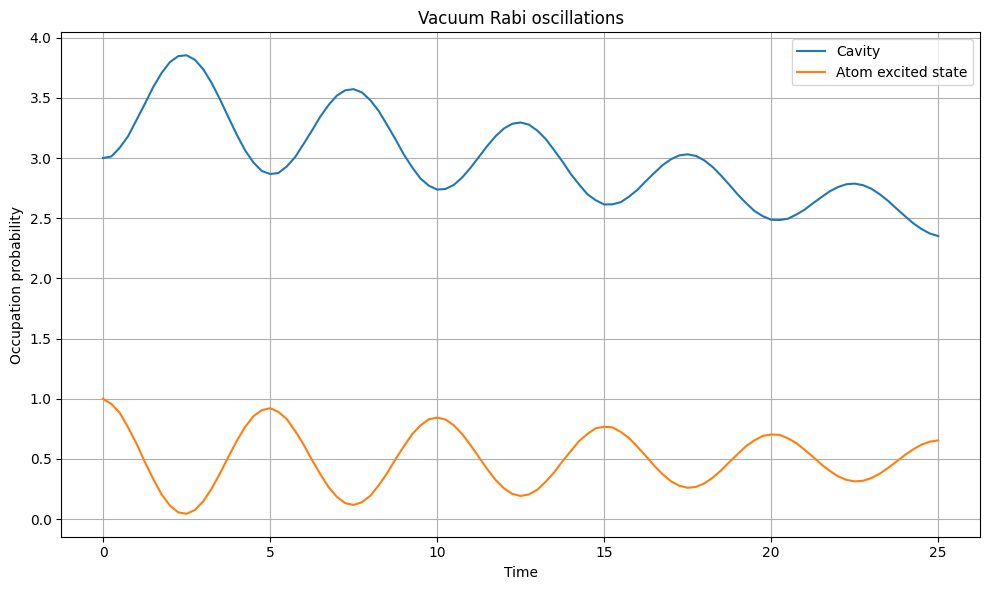

In [78]:
n_c = output.expect[0]
n_a = output.expect[1]

fig, ax = plt.subplots(1, 1, figsize=(10,6))

ax.plot(tlist, n_c, label="Cavity")
ax.plot(tlist, n_a, label="Atom excited state")
ax.legend(loc=0)
ax.set_xlabel('Time')
ax.set_ylabel('Occupation probability')
ax.set_title('Vacuum Rabi oscillations')
ax.grid()

fig.tight_layout()
plt.show()